# Optimizing parameters for membrane-image based cell segmentation

Workflows for segmenting cells from membrane staining images are often hard to optimize. In this notebook we demonstrate how to automatically optimizing the [seeded watershed algorithm](https://en.wikipedia.org/wiki/Watershed_(image_processing)), a common approach for this kind of image data.

In [1]:
from napari_workflow_optimizer import JaccardLabelImageOptimizer, Workflow

from skimage.io import imread
import napari_segment_blobs_and_things_with_membranes as nsbatwm
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
from the_segmentation_game.metrics import jaccard_index_sparse

We set up a workflow and insert a single operation, [Seeded Watershed using local minima as starting points](https://www.napari-hub.org/plugins/napari-segment-blobs-and-things-with-membranes#seeded-watershed-using-local-minima-as-starting-points) using the Napari plugin napari-segment-blobs-and-things-with-membranes. The algorithm has two parameters: `spot_sigma` for tuning how close seed points can be and `outline_sigma` for tuning how precise the membranes should be segmented.

In [2]:
w = Workflow()
w.set("labeled", # result image name
      nsbatwm.local_minima_seeded_watershed, # operation
      "input", spot_sigma=30, outline_sigma=10) # parameters

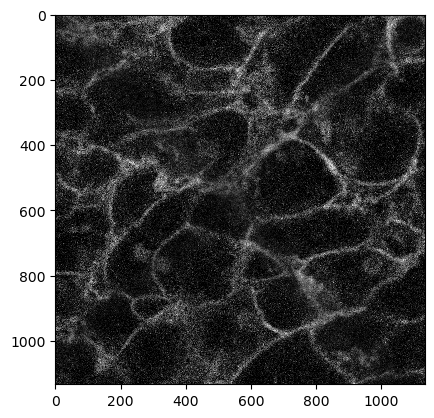

In [3]:
# image data source: scikit-image cells3d example, slice 28
w.set("input", imread("slice.tif"))
input_image = w.get("input")
cle.imshow(input_image)

We produce a first segmentation result that is oversegmented, there are obviously too many cells found.

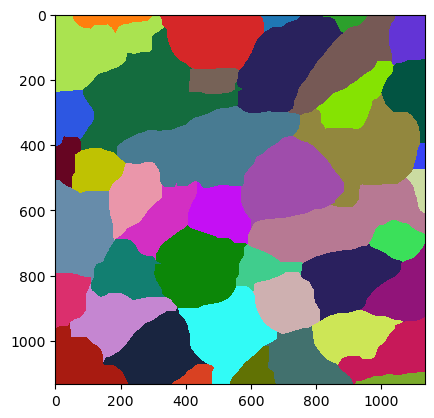

In [4]:
result = w.get("labeled")
cle.imshow(result, labels=True)

To give the segmentation algorithm some ground truth to compare segmentation results with, we use this sparse annotation image. It typically is enough to annotate some example cells accurately. Better spend time on making good segmentations and do not draw so many.

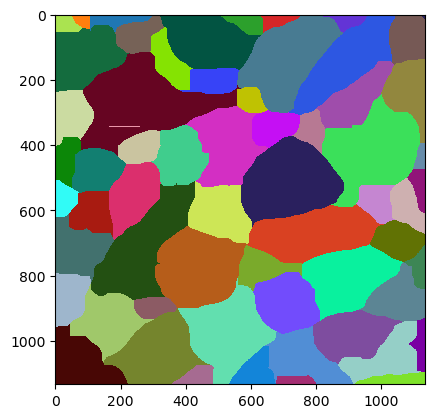

In [5]:
ground_truth = imread("slice_merged_labels.tif")
cle.imshow(ground_truth, labels=True)

We can then initiate the `JaccardLabelImageOptimizer`. Just for testing we inspect the current starting point for optimization.

In [6]:
jlio = JaccardLabelImageOptimizer(w)
jlio.get_numeric_parameters()

[30, 10]

We then start the optimization and afterwards print out the optimized parameter set.

In [7]:
best_param = jlio.optimize("labeled", ground_truth, maxiter=100)
best_param

array([19.37015626, 11.49819731])

We can also ask the optimizer to set these parameters for us and inspect the resulting label image.

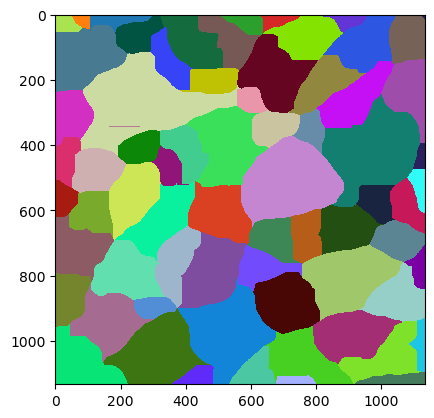

In [8]:
jlio.set_numeric_parameters(best_param)
cle.imshow(w.get("labeled"), labels=True)

The quality of this image can be measured by averaging the Jaccard Index of the three ground truth objects. [The Segmentation Game](https://github.com/haesleinhuepf/the-segmentation-game) library has a function for this.

In [9]:
jaccard_index_sparse(ground_truth, w.get("labeled"))

0.9377952804839831

Sometimes, the result is not perfect and we may want to change one parameter and see if the result can be improved.

In [10]:
new_starting_point = best_param.copy()
new_starting_point[0] = 20

new_starting_point

array([20.        , 11.49819731])

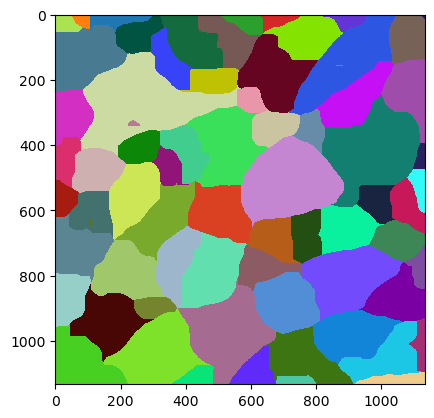

In [11]:
jlio2 = JaccardLabelImageOptimizer(w)
jlio2.set_numeric_parameters(new_starting_point)
cle.imshow(w.get("labeled"), labels=True)

We can then start a second attempt.

In [12]:
best_param = jlio.optimize("labeled", ground_truth, maxiter=100)
best_param

array([19.83967495, 11.49700618])

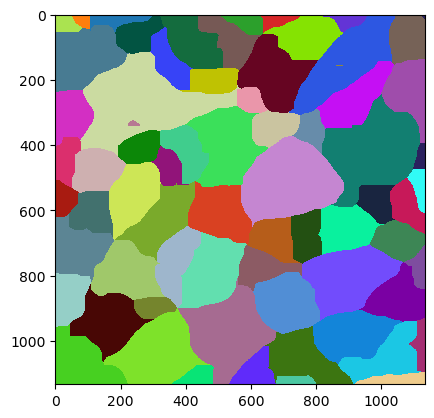

In [13]:
jlio.set_numeric_parameters(best_param)
cle.imshow(w.get("labeled"), labels=True)

In [14]:
jaccard_index_sparse(ground_truth, w.get("labeled"))

0.9111840104317906

In [15]:
import napari
viewer = napari.Viewer()

In [16]:
viewer.add_image(input_image)

<Image layer 'input_image' at 0x22ec68dd040>

In [17]:
viewer.add_labels(w.get("labeled"))

<Labels layer 'Labels' at 0x22ed9c51d00>

In [18]:
merged_labels = viewer.layers[-1].data

In [19]:
jaccard_index_sparse(ground_truth, merged_labels)

0.9111840104317906

In [20]:
import pyclesperanto_prototype as cle

In [21]:
cle.merge_annotated_touching_labels?

Signature:
cle.merge_annotated_touching_labels(
    labels: Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage],
    annotation_binary_mask: Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage],
    destination_labels: Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage] = None,
) -> Union[numpy.ndarray, pyclesperanto_prototype._tier0._pycl.OCLArray, pyopencl._cl.Image, pyclesperanto_prototype._tier0._pycl._OCLImage]
Docstring:
Takes a labelmap with n labels and merges all objects whose touching
areas are annotated in a given binary image.
Touching background is ignored.

Parameters
----------
labels : Image
annotation_binary_mask: Image
destination_labels: Image, optional

Returns
-------
destination_labels
File:      c:\structure\code\pyc